In [16]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/a2/48/d5da8591891327b0faf08179d420fba3893c6134bdd449497c5329e4cb01/xgboost-2.1.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 3.3 MB/s eta 0:00:38
   ---------------------------------------- 0.2/124.9 MB 3.0 MB/s eta 0:00:42
   ---------------------------------------- 0.3/124.9 MB 2.6 MB/s eta 0:00:48
   ---------------------------------------- 0.3/124.9 MB 2.6 MB/s eta 0:00:48
   ---------------------------------------- 0.3/124.9 MB 2.6 MB/s eta 0:00:48
   ---------------------------------------- 0.3/124.9 MB 2.6 MB/s eta 0:00:48
   ---------------------------------------- 0.5/124.9 MB 1.5 MB/s eta 0:01:21
   ---------------------------------------- 0.5/124.9 MB 1.5 MB/s eta 0:01:21
   ---------------------------------------- 0.5/124.9 MB 1.5 MB/s eta 0:01:21
   -------------------

In [42]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

import re

import warnings
warnings.filterwarnings('ignore')

In [43]:
df = pd.read_csv('HousingPrices-Amsterdam-August-2021.csv', thousands=r',',index_col=0)
df


,Address,Zip,Price,Area,Room,Lon,Lat
1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157
2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586
3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782
4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712
5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538
...,...,...,...,...,...,...,...
920,"Ringdijk, Amsterdam",1097 AE,750000.0,117,1,4.927757,52.354173
921,"Kleine Beerstraat 31, Amsterdam",1033 CP,350000.0,72,3,4.890612,52.414587
922,"Stuyvesantstraat 33 II, Amsterdam",1058 AK,350000.0,51,3,4.856935,52.363256
923,"John Blankensteinstraat 51, Amsterdam",1095 MB,599000.0,113,4,4.965731,52.375268


In [44]:
df.shape

(924, 7)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 924 entries, 1 to 924
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Address  924 non-null    object 
 1   Zip      924 non-null    object 
 2   Price    920 non-null    float64
 3   Area     924 non-null    int64  
 4   Room     924 non-null    int64  
 5   Lon      924 non-null    float64
 6   Lat      924 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 57.8+ KB


In [46]:
df.describe()

,Price,Area,Room,Lon,Lat
count,9.200000e+02,924.000000,924.000000,924.000000,924.000000
mean,6.220654e+05,95.952381,3.571429,4.888605,52.363326
std,5.389942e+05,57.447436,1.592332,0.053140,0.024028
min,1.750000e+05,21.000000,1.000000,4.644819,52.291519
25%,3.500000e+05,60.750000,3.000000,4.855834,52.352077
50%,4.670000e+05,83.000000,3.000000,4.886818,52.364631
75%,7.000000e+05,113.000000,4.000000,4.922337,52.377598
max,5.950000e+06,623.000000,14.000000,5.029122,52.423805


In [47]:
df.isnull().sum()

Address    0
Zip        0
Price      4
Area       0
Room       0
Lon        0
Lat        0
dtype: int64

In [48]:
df.duplicated().sum()

1

In [49]:
df.dropna(inplace=True)

In [50]:
df.drop_duplicates(inplace=True)

In [51]:

df.drop(columns=['Address', 'Zip'], axis=1, inplace=True)

In [52]:

numerical_columns = df.select_dtypes(exclude=object).columns.tolist()

In [53]:

for col in numerical_columns:
    upper_limit = df[col].mean() + 3 * df[col].std()
    lower_limit = df[col].mean() - 3 * df[col].std()
    df = df[(df[col] <= upper_limit) & (df[col] >= lower_limit)]

In [54]:
df

,Price,Area,Room,Lon,Lat
1,685000.0,64,3,4.907736,52.356157
2,475000.0,60,3,4.850476,52.348586
3,850000.0,109,4,4.944774,52.343782
4,580000.0,128,6,4.789928,52.343712
5,720000.0,138,5,4.902503,52.410538
...,...,...,...,...,...
920,750000.0,117,1,4.927757,52.354173
921,350000.0,72,3,4.890612,52.414587
922,350000.0,51,3,4.856935,52.363256
923,599000.0,113,4,4.965731,52.375268


In [55]:

def num_cols_vis(col):
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'{col} Distribution')
    plt.show()

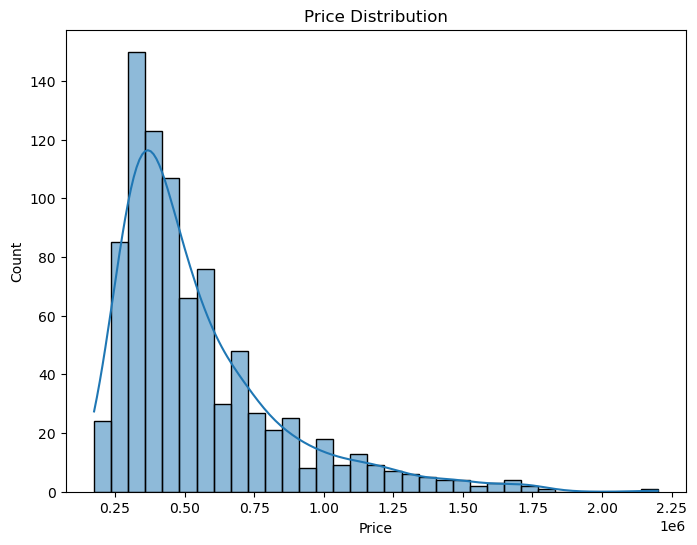

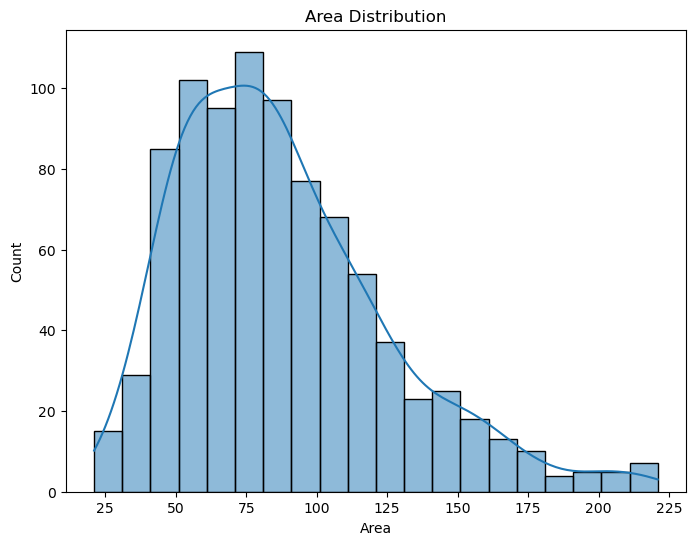

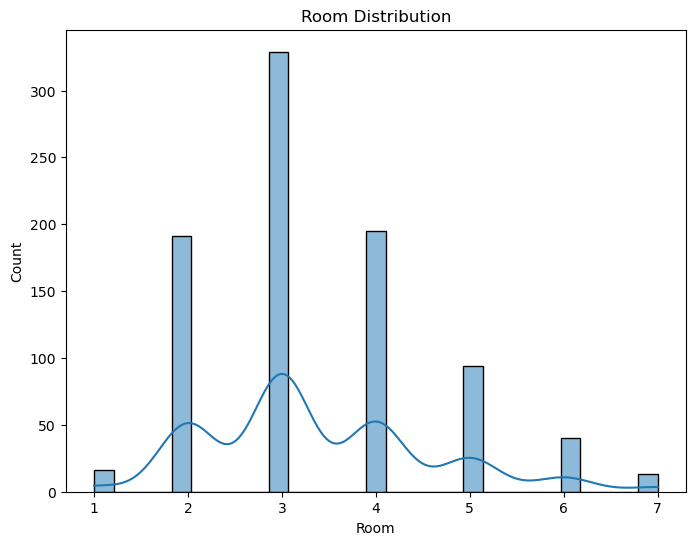

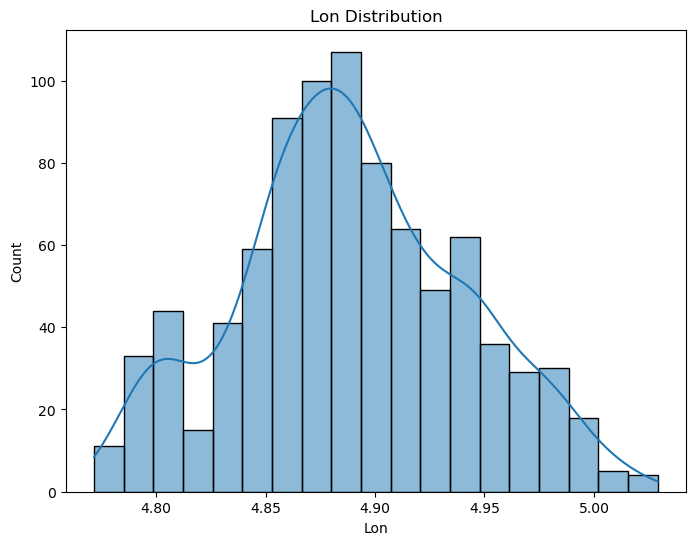

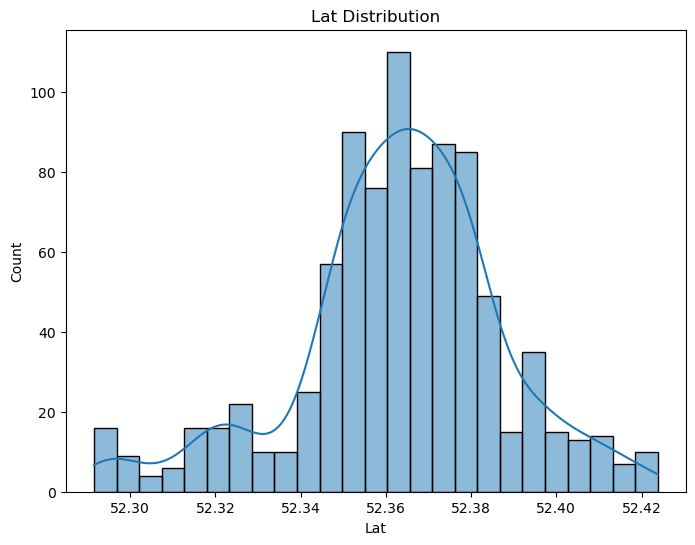

In [56]:

for col in numerical_columns:
    num_cols_vis(col)

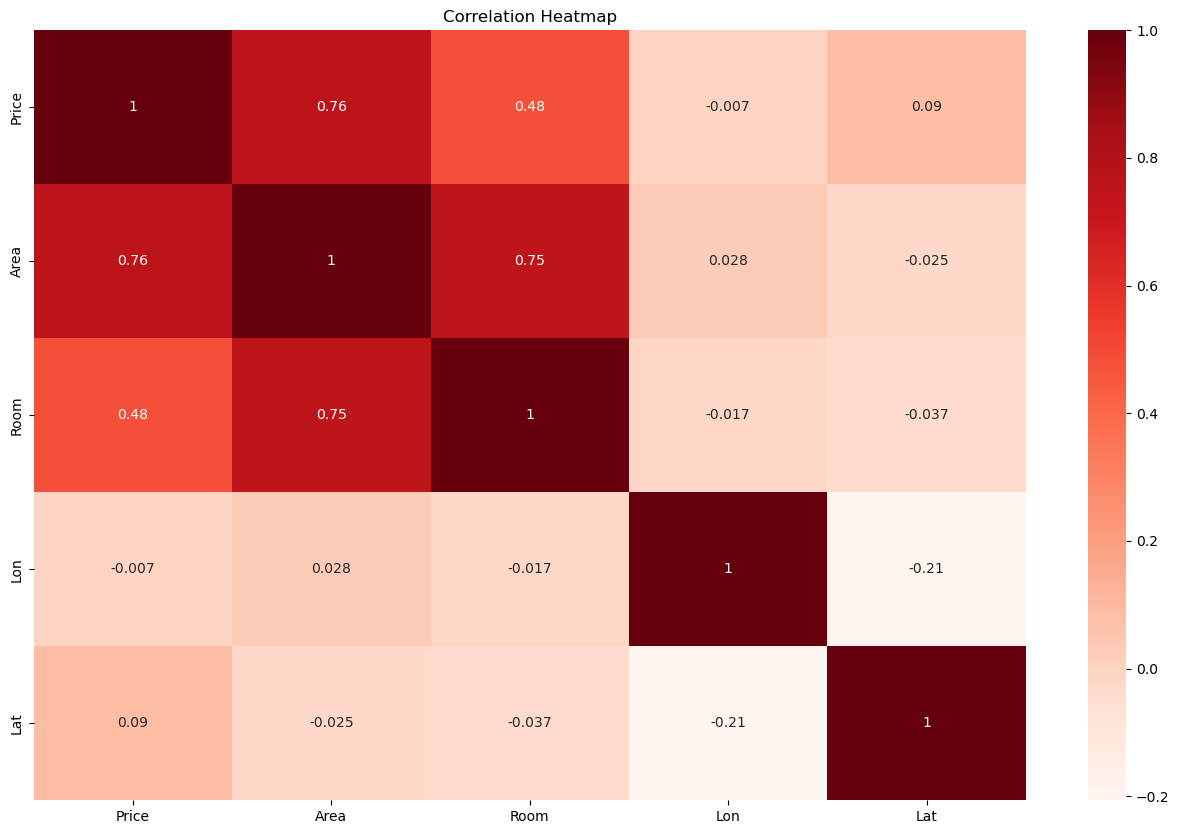

In [57]:
# Display the correlation matrix to find the relationship between each column and the target column
correlation_matrix = df[numerical_columns].corr()
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds')
plt.title("Correlation Heatmap")
plt.show()

In [58]:
X = df.drop(['Price'], axis=1) 
y = df['Price']

In [59]:
X

,Area,Room,Lon,Lat
1,64,3,4.907736,52.356157
2,60,3,4.850476,52.348586
3,109,4,4.944774,52.343782
4,128,6,4.789928,52.343712
5,138,5,4.902503,52.410538
...,...,...,...,...
920,117,1,4.927757,52.354173
921,72,3,4.890612,52.414587
922,51,3,4.856935,52.363256
923,113,4,4.965731,52.375268


In [60]:
y

1      685000.0
2      475000.0
3      850000.0
4      580000.0
5      720000.0
         ...   
920    750000.0
921    350000.0
922    350000.0
923    599000.0
924    300000.0
Name: Price, Length: 878, dtype: float64

In [61]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# Define and Train Models
# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# XGBoost
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [63]:
rf.score(X_test, y_test)

0.8223003687252834

In [64]:
xgb.score(X_test, y_test)

0.8195607873862968

In [65]:

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}


rf_grid = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                       param_grid=rf_params,
                       cv=3,
                       scoring='neg_mean_squared_error',
                       verbose=1)

rf_grid.fit(X_train, y_train)
print("Best parameters for Random Forest:", rf_grid.best_params_)
print("Best score for Random Forest:", np.sqrt(-rf_grid.best_score_))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best score for Random Forest: 138974.7844996747


In [66]:

xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9]
}

xgb_grid = GridSearchCV(estimator=XGBRegressor(random_state=42),
                        param_grid=xgb_params,
                        cv=3,
                        scoring='neg_mean_squared_error',
                        verbose=1)

xgb_grid.fit(X_train, y_train)
print("Best parameters for XGBoost:", xgb_grid.best_params_)
print("Best score for XGBoost:", np.sqrt(-xgb_grid.best_score_))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}
Best score for XGBoost: 141074.8895943237
